# Multi-Model prediciton: Age, Gender, and Ethnicity 

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import os

from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical  


# Configurations

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32

## Importing Dataset

In [2]:
dataframe = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
dataframe.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


Displays a single face image from the dataset, reconstructed from its pixel values.

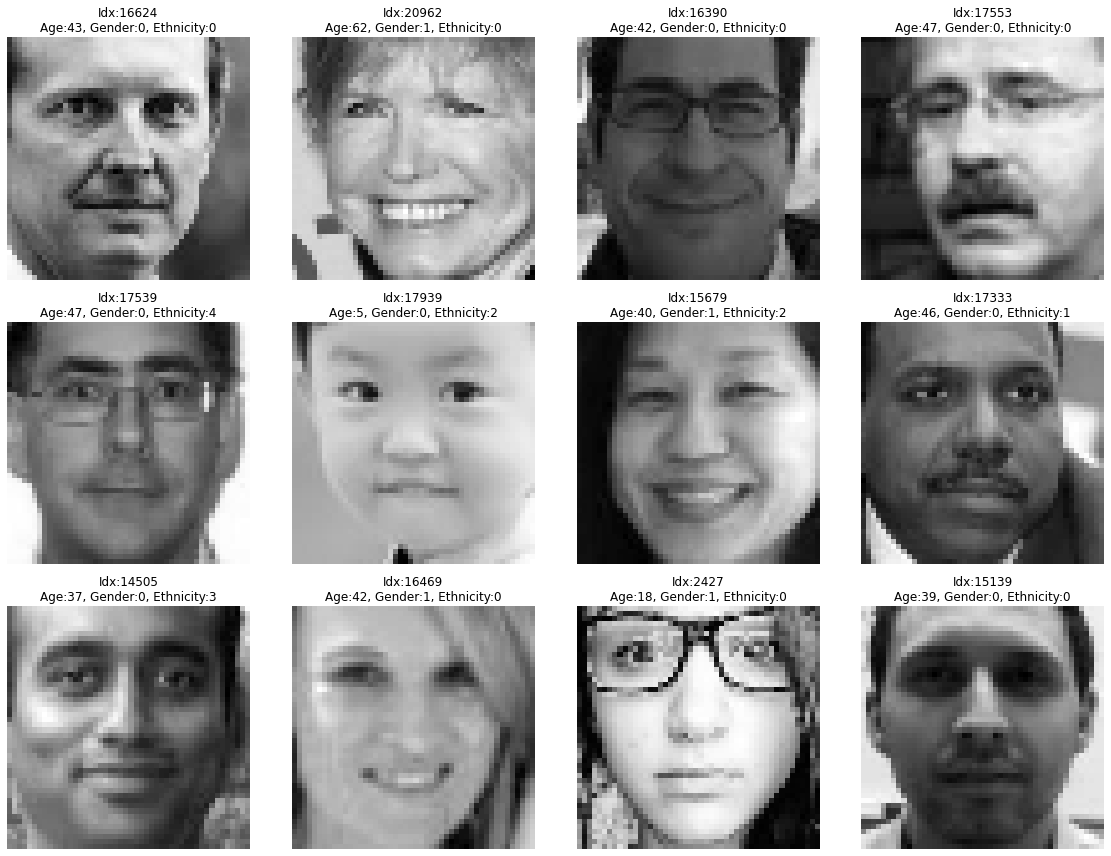

In [ ]:
# Display a group of sample images with labels for age, gender, ethnicity, and image index

num_samples = 8  # Number of images to display
indices = np.random.choice(len(dataframe), num_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    image = np.fromstring(dataframe['pixels'][idx], sep=' ', dtype=np.uint8).reshape((48, 48))
    age = dataframe['age'][idx]
    gender = dataframe['gender'][idx]
    ethnicity = dataframe['ethnicity'][idx]
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Idx:{idx}\nAge:{age}, Gender:{gender}, Ethnicity:{ethnicity}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Data Generator

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size = 32,
                 input_size=(48, 48, 3),
                 shuffle=True,
                 data_augmentation = False):
        self.df = df
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation
        self.var = 1
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            fill_mode = 'nearest',
            zoom_range = (1, 1.1),
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10
        )
        
        self.images = []
        self.age_labels = []        
        self.ethnicity_labels = []
        self.gender_labels = []
        
        for index, row in tqdm(df.iterrows()):
            image = np.fromstring(row['pixels'], sep = ' ', dtype = np.uint8).reshape((48,48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
            self.images.append(image)
            
            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])
            
            
        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)
        
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
        self.gender_labels = self.gender_labels[p]
        
        self.n = len(self.df)
        
    
    def __getitem__(self, index):
        images = []
        
        for i in range(self.batch_size):
            image = self.images[index * self.batch_size + i]
            
            if self.data_augmentation:                
                image = self.imageGenerator.random_transform(image)
                
            images.append(image)
            
        s = slice(self.batch_size * index, (index + 1) * self.batch_size)
        return np.array(images), (self.age_labels[s], self.ethnicity_labels[s], self.gender_labels[s])
    
    def __len__(self):
            
        return self.n // self.batch_size
    
    def on_epoch_end(self):
        
        #Random permutation
        p = np.random.permutation(len(self.age_labels))
        self.images = self.images[p]
        self.age_labels = self.age_labels[p]
        self.ethnicity_labels = self.ethnicity_labels[p]
        self.gender_labels = self.gender_labels[p]

In [7]:
#Divide into train and validation
msk = np.random.rand(len(dataframe)) < 0.8
train = dataframe[msk]
val = dataframe[~msk]

train_dataset = CustomDataGen(train, data_augmentation = True)
val_dataset = CustomDataGen(val)

18782it [00:03, 6059.14it/s]
4923it [00:00, 6541.10it/s]


236
26.0 [0. 1. 0. 0. 0.] 0.0


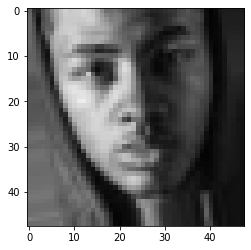

In [8]:
train_dataset.on_epoch_end()
x, y = train_dataset[450]
print(x[21].max())
print(y[0][0], y[1][0], y[2][0])
plt.imshow(x[0])

## Building Model

In [9]:
def build_model(input_shape = (48,48,3)):
    
    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output    
    
    
    def build_age_branch(input_tensor): 
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = None, name = 'age_output')(x)
    
        return x
    
    def build_etchnicity_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'ethnicity_output')(x)
    
        return x
    
    def build_gender_branch(input_tensor): 
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)
    
        return x
    
    x = tf.keras.layers.Flatten()(output_layer)       
    output_age = build_age_branch(x)
    output_ethnicity = build_etchnicity_branch(x)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, [output_age, output_ethnicity, output_gender])
    
    return model
    

In [10]:
model = build_model()
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 48, 48, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 48, 48, 3)    0           tf.cast[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 48, 48, 3)    0           tf.__operators__.getitem[0][0]   
_____________________________

## Training the Model

In [11]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5], 
              metrics = {'age_output': 'mean_absolute_error', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)  ## Reduce learning rate when a metric has stopped improving.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)  ## Early stopping (stops training when validation doesn't improve for {patience} epochs)
save_best = tf.keras.callbacks.ModelCheckpoint('weights_v1.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = True)  ## Saves the best version of the model to disk (as measured on the validation data set)  

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau])

Epoch 1/70
586/586 [==============================] - 854s 1s/step - loss: 1.9379 - age_output_loss: 1190.9822 - ethnicity_output_loss: 1.0678 - gender_output_loss: 0.4260 - age_output_mean_absolute_error: 31.8870 - ethnicity_output_accuracy: 0.6353 - gender_output_accuracy: 0.8107 - val_loss: 1.8974 - val_age_output_loss: 781.7017 - val_ethnicity_output_loss: 1.9344 - val_gender_output_loss: 0.2971 - val_age_output_mean_absolute_error: 25.7600 - val_ethnicity_output_accuracy: 0.4808 - val_gender_output_accuracy: 0.8740
Epoch 2/70
586/586 [==============================] - 846s 1s/step - loss: 1.3977 - age_output_loss: 828.0150 - ethnicity_output_loss: 0.8190 - gender_output_loss: 0.3203 - age_output_mean_absolute_error: 26.5284 - ethnicity_output_accuracy: 0.7235 - gender_output_accuracy: 0.8658 - val_loss: 1.5454 - val_age_output_loss: 870.0883 - val_ethnicity_output_loss: 1.0876 - val_gender_output_loss: 0.2630 - val_age_output_mean_absolute_error: 27.8890 - val_ethnicity_output_acc

## Evaluating the Model

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.show()

## Testing the Model

In [ ]:
model.load_weights('weights_v1.h5')
model.evaluate(val_dataset)

In [ ]:
names_ethnicity = ['white', 'black', 'asian', 'indian', 'other']
name_genders = ['male', 'female']

In [ ]:
images, labels = val_dataset[22]
index = 0

p = model.predict(images)

gender_predictions = tf.where(p[2] > 0.5, 1, 0)
plt.title(f'Prediction: {p[0][index].astype(np.int)[0]} years, {names_ethnicity[p[1][index].argmax()]}, {name_genders[gender_predictions[index][0]]}\n'+
         f'Real: {int(labels[0][index])} years, {names_ethnicity[labels[1][index].argmax()]}, {name_genders[int(labels[2][index])]}')
plt.imshow(images[index])
plt.show()